<br>
<font color="#500000" size=15 style="margin:2cm"> AGGREGATIBACTER FUSE</font>



In [1]:
# importing modules
import matplotlib.pyplot as plt
import numpy as np
from skfusion import fusion
from cross_validation import *
import pickle

from scipy.stats import ranksums
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.style.use('ggplot')

#Matrices import

Load in all the matrices!

In [2]:
prot_rna = pickle.load(open('../matrices/pickles/cr_z-score_raw.pkl', 'rb'))
secretion_prot = pickle.load(open('../matrices/pickles/signalP.pkl', 'rb'))
rna_expression = pickle.load(open('../matrices/pickles/MA_exp.pkl', 'rb'))
s4te_prot = np.load(open('../matrices/pickles/S4TE.npy', 'rb'))
OG_prot = np.load(open('../matrices/pickles/OG_prot.npy', 'rb')) # this is orthology function
rna_GO = np.load(open('../matrices/pickles/HSgene_GO.npy', 'rb'))

gproOG_prot = np.load(open('../matrices/pickles/aaprot_gprobOG.npy', 'rb'))
hsgene_gproOG = np.load(open('../matrices/pickles/HSgene_GO.npy', 'rb'))
aaexp_prot = np.load(open('../matrices/pickles/aa_fc_expressions.npy', 'rb'))

# Data transformation

In [3]:
# remove data for genes with no catrapid prediction
selection = prot_rna.any(axis=1)
prot_rna = prot_rna[selection,:]
secretion_prot = secretion_prot[:, selection]
s4te_prot = s4te_prot[:, selection]
OG_prot = OG_prot[:, selection]
gproOG_prot = gproOG_prot.T[:, selection]
# Addd pseudo rows 
# TODO: remove when fixed!
secretion_prot = np.vstack((secretion_prot, secretion_prot, secretion_prot, secretion_prot, secretion_prot))

rna_expression = rna_expression.reshape(rna_expression.shape[0],1)
rna_expression = np.hstack((rna_expression, rna_expression, rna_expression, rna_expression, rna_expression))

aaexp_prot = np.reshape(aaexp_prot, (1, aaexp_prot.size))
aaexp_prot = np.vstack((aaexp_prot, aaexp_prot, aaexp_prot, aaexp_prot, aaexp_prot))[:, selection]

# Add sum to S4te Results
s4te_prot[1,:] = s4te_prot[1,:] * 3
s4te_sum = s4te_prot.sum(axis=0) / s4te_prot.sum(axis=0).max()
s4te_prot = np.vstack((s4te_prot,s4te_sum))

# Display shapes
print('secretion_prot:', secretion_prot.shape)
print('rna_expression:', rna_expression.shape)
print('prot_rna:', prot_rna.shape)
print('s4te_prot:', s4te_prot.shape)
print('OG_prot:', OG_prot.shape)
print('gproOG_prot', gproOG_prot.shape)
print('hsgene_gproOG', gproOG_prot.shape)
print('aaexp_prot', aaexp_prot.shape)
print('rna_GO', rna_GO.shape)

secretion_prot: (5, 2001)
rna_expression: (7097, 5)
prot_rna: (2001, 7097)
s4te_prot: (13, 2001)
OG_prot: (22, 2001)
gproOG_prot (825, 2001)
hsgene_gproOG (825, 2001)
aaexp_prot (5, 2001)
rna_GO (7097, 285)


# Data fusion setup

In [4]:
# Define names
secretion = fusion.ObjectType('SignalP')
prot = fusion.ObjectType('AAprot')
genes = fusion.ObjectType('HSgenes')
GO = fusion.ObjectType('GOterms')

# TODO: lower when possible
expr = fusion.ObjectType('HSexpression')
t4e = fusion.ObjectType('Type4eff')
OGfg = fusion.ObjectType('ontology_group_functions')
gproOG = fusion.ObjectType('ontology_groups')
aaexp = fusion.ObjectType('AAexpression')
# Define relations
relations = [fusion.Relation(secretion_prot, secretion, prot),
             fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(rna_expression, genes, expr),
             fusion.Relation(OG_prot, OGfg, prot),
             fusion.Relation(gproOG_prot, gproOG, prot),
             fusion.Relation(hsgene_gproOG, genes, gproOG),
             fusion.Relation(aaexp_prot, aaexp, prot),
             fusion.Relation(rna_GO, genes, GO)]



# Validation Functions

In [5]:
def shuffle_rows(my_array, ssed = 100):
    """
    Returns array with rows shuffled
    """
    np.random.seed(ssed)
    sh_idx = np.arange(my_array.shape[0])
    np.random.shuffle(sh_idx)
    return my_array[sh_idx,:]

def shuffle_cols(my_array, ssed = 100):
    """
    Returns array with rows shuffled
    """
    np.random.seed(ssed)
    sh_idx = np.arange(my_array.shape[1])
    np.random.shuffle(sh_idx)
    return my_array[:, sh_idx]


def make_sublot(splot, val1, val2, title=None, abline=None, disleg=False):
    """
    Creates subplot
    """
    splot.text(0.01,0.01, 'P vrednost: {:.5f} (Wilcoxonov test)'
               .format(ranksums(val1, val2)[1]), transform=splot.transAxes)
    if title:
        splot.set_title(title)
    splot.plot([1]*len(val1), val1, 'or');
    
    
    splot.plot([1.1]*len(val2), val2, 'ob');
    splot.set_xlim(0.9, 1.2);
    
    # Samples average
    splot.plot([1], np.mean(val1), 'og', label='Povprečna vrednost')
    splot.plot([1.1], np.mean(val2), 'og')
    
    # Pure average
    if abline:
        splot.plot([0.9, 1.2], [abline]*2, 'k', label='Povprečje brez dodatnih virov')
    if disleg:
        splot.legend(bbox_to_anchor=(1.05, 1), loc=2)
    # splot.legend(loc = 'best')
        
def make_graphs(auc1, auc2, dev1=None, dev2=None, abline1=None, abline2=None):
    """
    Creates validation plot
    """
    if dev1:
        splot = plt.subplot(1, 2, 1)
    else: 
        splot = plt.subplot(1, 1, 1)
    plt.xticks([1,1.1], ['Podatki', 'Permutacija\nPodatkov'], rotation='vertical');
    make_sublot(splot, auc1, auc2, title='AUC vrednosti', abline=abline1)
    
    if dev1:
        splot = plt.subplot(1, 2, 2)
        plt.xticks([1,1.1], ['Podatki', 'Permutacija\nPodatkov'], rotation='vertical');
        make_sublot(splot, dev1, dev2, title='Absolutna napaka', abline=abline2, disleg=True)
        
def row_cross_validate(relations, cv_fold=10, th=2.5, random_state=1, shuffle_test=None, graphlines = [None, None]):
    """
    Performs cross valiation on give first matrix of relation and 
    returns average AUC score and average deviation.
    """
    auc_vals = []
    avr_dev = []
    orig_matrix = relations[0].data
    for cv_matrix, elements in matrix_cv_setup(orig_matrix, n_fold=cv_fold, alternative=0, by_row=True):
        relations[0].data = cv_matrix
        reconst_mat = dfmf_n_reconstruct(relations, random_state=random_state)
        auc_vals.append(auc_value(orig_matrix, reconst_mat, elements, treshold=th, by_row=True))
        avr_dev.append(avr_res(orig_matrix, reconst_mat, elements, by_row=True))

    print('\tAUC value is:', np.mean(auc_vals))
    print('\t\tall values:', auc_vals)
    print()
    print('\tAverage deviation is:', np.mean(avr_dev))
    print('\t\tall values:', avr_dev)
    relations[0].data = orig_matrix
    
    if shuffle_test:
        auc_vals2 = []
        avr_dev2 = []
        if len(relations) > 2:
            print('Sorry, can not handle this for now!' )
            return 
        elif  shuffle_test == 'row':
            relations[1].data = shuffle_rows(relations[1].data)
        
        elif shuffle_test == 'col': 
            relations[1].data = shuffle_cols(relations[1].data)
        else:
            print('Unknown shuffle test')
            return 
        # print(relations[1].data)
        print('\n\nShuffling by {}'.format(shuffle_test))
        for cv_matrix, elements in matrix_cv_setup(orig_matrix, n_fold=cv_fold, alternative=0, by_row=True):
            relations[0].data = cv_matrix
            reconst_mat = dfmf_n_reconstruct(relations, random_state=random_state)
            auc_vals2.append(auc_value(orig_matrix, reconst_mat, elements, treshold=th, by_row=True))
            avr_dev2.append(avr_res(orig_matrix, reconst_mat, elements, by_row=True))

        print('\tAUC value is:', np.mean(auc_vals2))
        print('\t\tall values:', auc_vals2)
        print()
        print('\tAverage deviation is:', np.mean(avr_dev2))
        print('\t\tall values:', avr_dev2)
        relations[0].data = orig_matrix
        make_graphs(auc_vals, auc_vals2, avr_dev, avr_dev2, graphlines[0], graphlines[1])
        
    return np.mean(auc_vals), np.mean(avr_dev)
    
def dfmf_n_reconstruct(relationships, random_state=1):
    """
    Given relationships, reconstructs the matrix
    """
    fusion_graph = fusion.FusionGraph(relations)

    fuser = fusion.Dfmf(random_state=random_state)
    fuser.fuse(fusion_graph)
    return fuser.complete(fusion_graph['catrapid'])


# Predictions and Validations

We are calculating for top 11.8882% interactions
Only Interactions:
	AUC value is: 0.497491775724
		all values: [0.49956634945534978, 0.49753567018409645, 0.49477816918498829, 0.49325716574635886, 0.49225827417964518, 0.50044646074875432, 0.50889332606035831, 0.49389681046067829, 0.49491996145403866, 0.49936556976645907]

	Average deviation is: 0.599167066679
		all values: [0.61176823491787213, 0.60343892979451352, 0.5785931315290741, 0.58926597296102889, 0.58969791792955584, 0.5993877122547091, 0.61833112600381923, 0.59908500270418852, 0.61050601234047797, 0.59159662635049937]


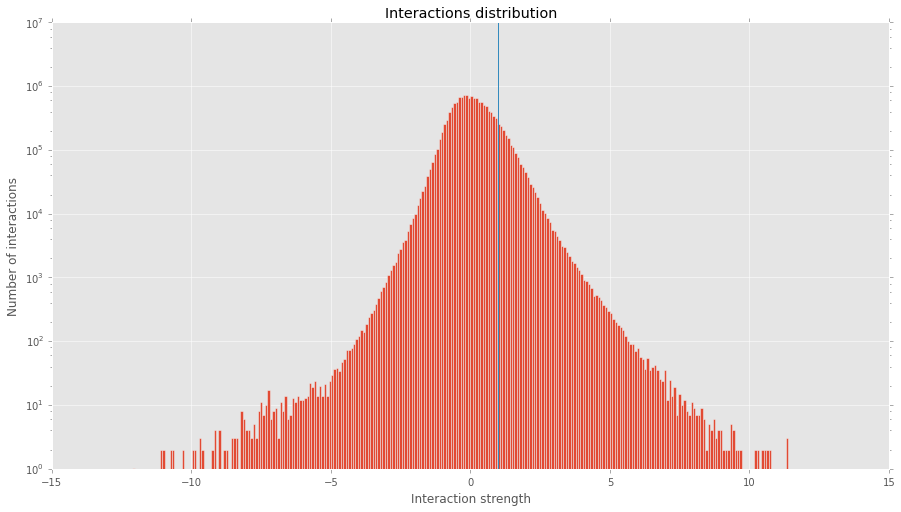

In [6]:
auc_th = 1

plt.hist(prot_rna.flatten(), bins= 300, log=True);
plt.plot((auc_th, auc_th), (0, 10**7));
plt.title("Interactions distribution");
plt.xlabel("Interaction strength");
plt.ylabel("Number of interactions");

print('We are calculating for top {:.4f}% interactions'.format(np.sum(prot_rna > auc_th) / prot_rna.size *100))

print('Only Interactions:')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid')]
rauc, rdev = row_cross_validate(relations, cv_fold=10, th=auc_th)

with Expression:
	AUC value is: 0.495320308796
		all values: [0.49361004783495205, 0.49545821127480177, 0.48857216078985044, 0.48910021501582324, 0.49173036752080312, 0.49829815601801442, 0.50015441008169004, 0.49501131589932906, 0.49336802092315885, 0.50790018260384806]

	Average deviation is: 0.599167065885
		all values: [0.61176820118571673, 0.60343891535670446, 0.57859312476107849, 0.58926599799589496, 0.58969792353984207, 0.59938770464995095, 0.61833114455589988, 0.59908499310953622, 0.61050602056087244, 0.59159663313484101]


Shuffling by row
	AUC value is: 0.500312741742
		all values: [0.49558022330995005, 0.49828430204234286, 0.49387996956812008, 0.50995916351212967, 0.49503628815567535, 0.50395935361445998, 0.50011407247673401, 0.49763096112884642, 0.49407410302833021, 0.51460898058061977]

	Average deviation is: 0.599167070525
		all values: [0.61176820285242817, 0.60343892337893323, 0.57859312590341694, 0.58926601291927894, 0.5896979252098673, 0.59938771358444332, 0.618331147

(0.49532030879622707, 0.59916706588503366)

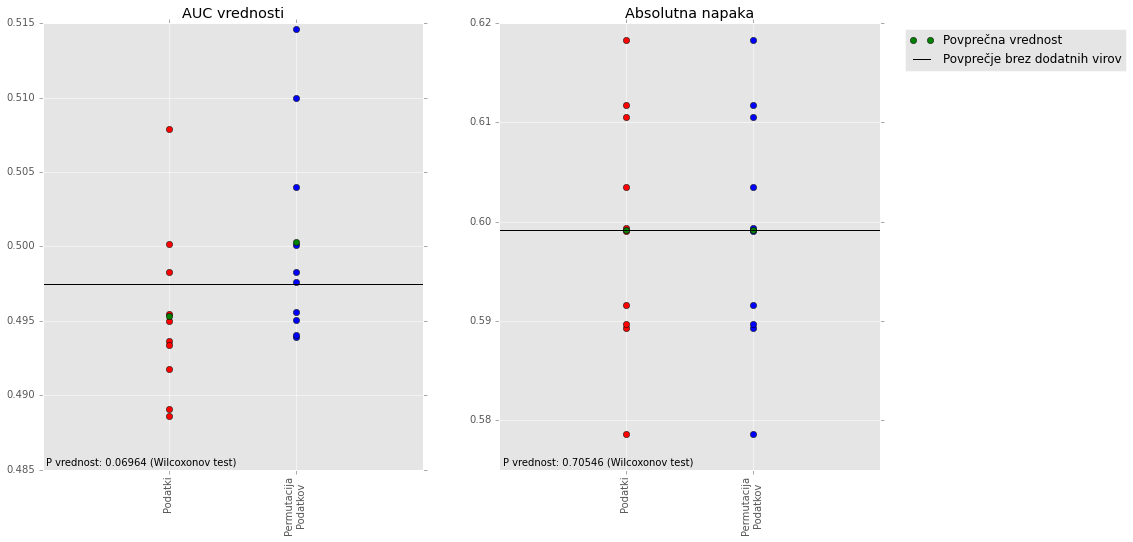

In [7]:
print('with Expression:')

relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(rna_expression, genes, expr)]

row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='row', graphlines = [rauc, rdev])

with Secretion:
	AUC value is: 0.359073891438
		all values: [0.35051275787106595, 0.3554131628934854, 0.32657070145118133, 0.32677145141444686, 0.32807727887663807, 0.33290590203384662, 0.42967453200065175, 0.33865195778831375, 0.34917756030901675, 0.45298360974145402]

	Average deviation is: 0.598831056697
		all values: [0.61132469282298618, 0.60267736159811158, 0.57834286862991624, 0.58878002025939946, 0.58953569132990458, 0.59921861985251546, 0.61823158629194241, 0.59868721121838087, 0.60999670381890858, 0.59151581114490948]


Shuffling by col
	AUC value is: 0.36868290732
		all values: [0.35477330736131629, 0.35528851121745147, 0.32306257596200899, 0.32797203199086461, 0.33206496066913743, 0.33164525651887988, 0.50882984801780118, 0.33942189932428779, 0.34840079415445141, 0.46536988798437839]

	Average deviation is: 0.598761084123
		all values: [0.6112295385733918, 0.60269390041446969, 0.57822499225782731, 0.58865280314094526, 0.58951555605657369, 0.59915889242434106, 0.618170398658

(0.35907389143801005, 0.59883105669669745)

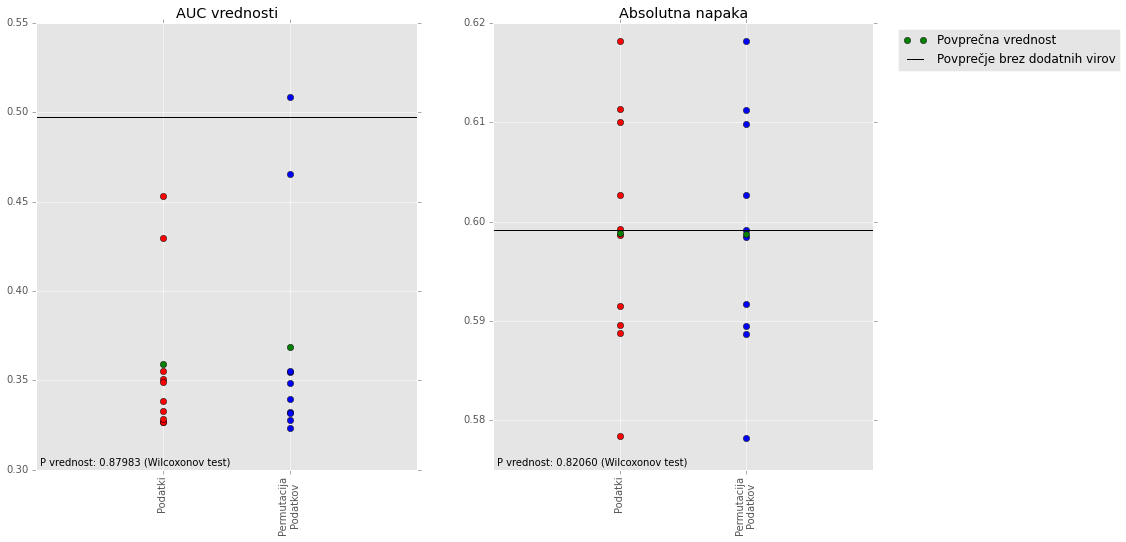

In [8]:
print('with Secretion:')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(secretion_prot, secretion, prot)]

row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])

with S4TE
	AUC value is: 0.476063056223
		all values: [0.56048302548780782, 0.5606172492027639, 0.41145836506913469, 0.43905824642328928, 0.49393790934507864, 0.35230463010223412, 0.57609333995360745, 0.40901441923976789, 0.38752165875678479, 0.57014171865292018]

	Average deviation is: 0.59818296647
		all values: [0.61083006558244735, 0.6022871540547966, 0.57793888054795817, 0.58853434912909797, 0.58839367634403239, 0.59860549113421746, 0.61691857606965517, 0.59831701323563824, 0.60965415115538202, 0.59035030744716654]


Shuffling by col
	AUC value is: 0.531785744283
		all values: [0.55244225293320637, 0.58842392912776864, 0.76390617928861393, 0.48624285281168883, 0.44701375124158244, 0.73794355808824896, 0.47481709009074596, 0.35526260243972396, 0.35560271788356956, 0.55620250892562695]

	Average deviation is: 0.595051516932
		all values: [0.61090753029919009, 0.60260859854912596, 0.56825659859300415, 0.58845158171790757, 0.58876520043916425, 0.57446177358945349, 0.61817040525894518,

(0.47606305622333889, 0.59818296647003921)

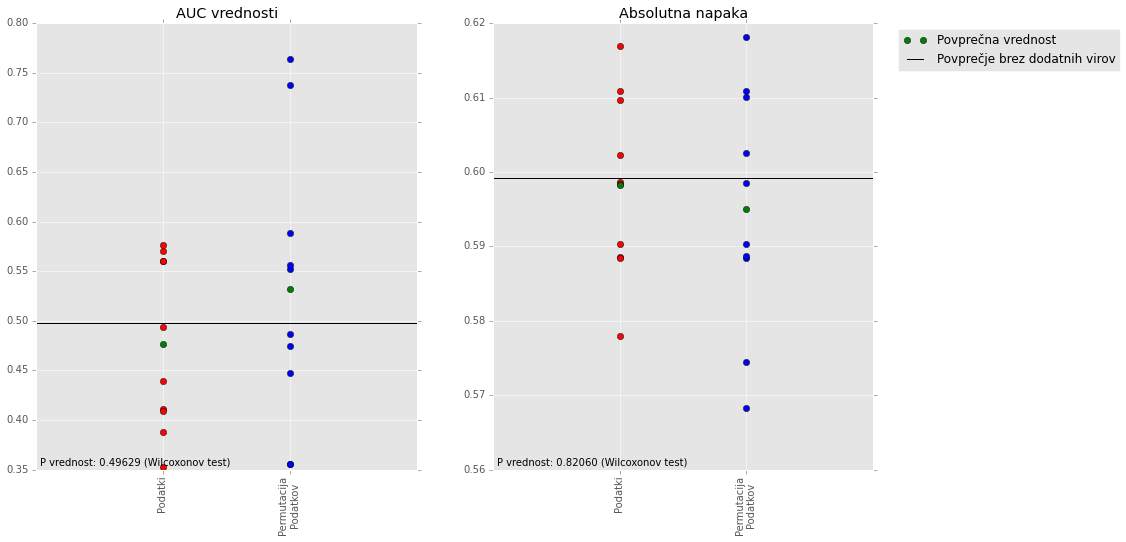

In [9]:
print('with S4TE')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(s4te_prot, t4e, prot)]
row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])

with AA expression change
	AUC value is: 0.500080522292
		all values: [0.50704640491941444, 0.5011540191087992, 0.50629386196694515, 0.50138128803733806, 0.49547414245004162, 0.488995107393701, 0.4993820154459141, 0.50018142671644561, 0.49874384766638308, 0.50215310921466783]

	Average deviation is: 0.599274535006
		all values: [0.6118356665260235, 0.60348908325390738, 0.578627821900772, 0.58936754662357627, 0.58979123723478355, 0.59956843509375035, 0.61842935032378876, 0.59921160966171672, 0.61053277080480362, 0.59189182863913226]


Shuffling by col
	AUC value is: 0.498939610635
		all values: [0.49906634834415919, 0.51163734686207729, 0.47673957743013984, 0.49763021242706107, 0.50724283437024043, 0.50061688901574586, 0.50794982407153044, 0.50376877360785943, 0.48401990730574668, 0.50072439291978177]

	Average deviation is: 0.599269198489
		all values: [0.61184325559378938, 0.60336386192864833, 0.57866894698321303, 0.58934010858025043, 0.589837933630319, 0.59954320856855159, 0.61854358

(0.50008052229196509, 0.59927453500622552)

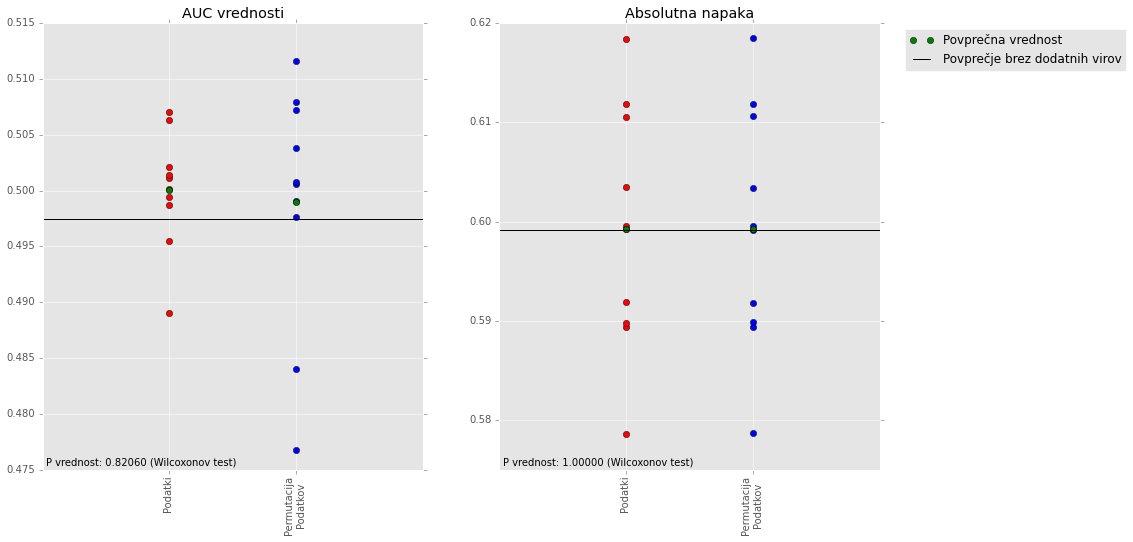

In [10]:
print('with AA expression change')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(gproOG_prot, gproOG, prot)]
row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])

with Orthology functional groups
	AUC value is: 0.423120437736
		all values: [0.46836395705048084, 0.49107386584141738, 0.35987743329044419, 0.35642359924954659, 0.39671625956253626, 0.43415677649112427, 0.42297522306576579, 0.42477373477590097, 0.48428230506141645, 0.39256122297635176]

	Average deviation is: 0.599773139322
		all values: [0.61246502753101462, 0.6037735923095171, 0.58028485495732784, 0.58919954952758702, 0.58974316688582107, 0.59976079216318645, 0.61955735727075489, 0.5998932329164075, 0.61083255179553819, 0.59222126786172957]


Shuffling by col
	AUC value is: 0.431242215054
		all values: [0.44149671722361067, 0.45955747799660607, 0.37291224916461391, 0.34718480298823734, 0.36802863130734914, 0.50197344342011729, 0.50871915455107597, 0.48078381649624891, 0.4579693467970391, 0.37379651059695029]

	Average deviation is: 0.599036216336
		all values: [0.61161594132813479, 0.60354154795011428, 0.57884991667883001, 0.5897113532535152, 0.58970760675932166, 0.59866777565007345

(0.42312043773649843, 0.59977313932188836)

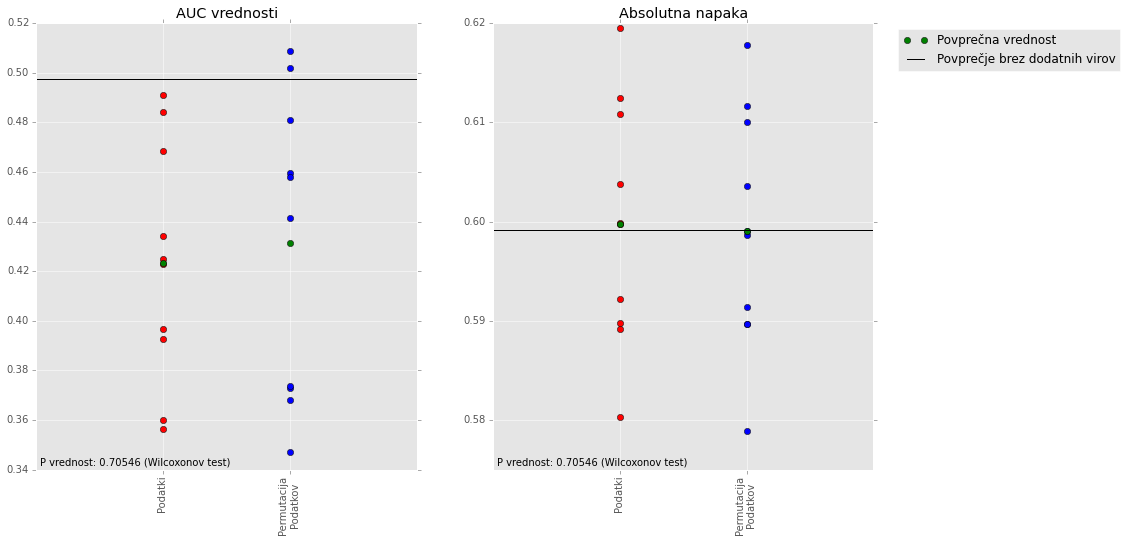

In [11]:
print('with Orthology functional groups')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(OG_prot, OGfg, prot)]
row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])


with GO terms:
	AUC value is: 0.497853058423
		all values: [0.49812503206291692, 0.49649983864887454, 0.49456764308546503, 0.49396983913715686, 0.49841668681484658, 0.49013145854478823, 0.5040351007168945, 0.49855212041284136, 0.49737254540848985, 0.50686031940047738]

	Average deviation is: 0.599167070822
		all values: [0.61176820585570479, 0.60343893750687883, 0.57859312965338783, 0.58926600619994485, 0.58969794244278029, 0.59938765867172117, 0.61833114536541101, 0.59908501461357511, 0.61050601980267294, 0.59159664810887846]


Shuffling by row
	AUC value is: 0.498469792627
		all values: [0.49919299735736722, 0.49580971366296284, 0.49450166427321884, 0.49685539756539343, 0.50010015672969921, 0.4928054027042823, 0.50403814437254102, 0.4973315202821012, 0.4962634850309306, 0.50779944429024426]

	Average deviation is: 0.599167070401
		all values: [0.61176822590178115, 0.60343893333405507, 0.57859312988823508, 0.58926601104726695, 0.58969794697942457, 0.59938765976770325, 0.61833115131712

(0.4978530584232751, 0.59916707082209553)

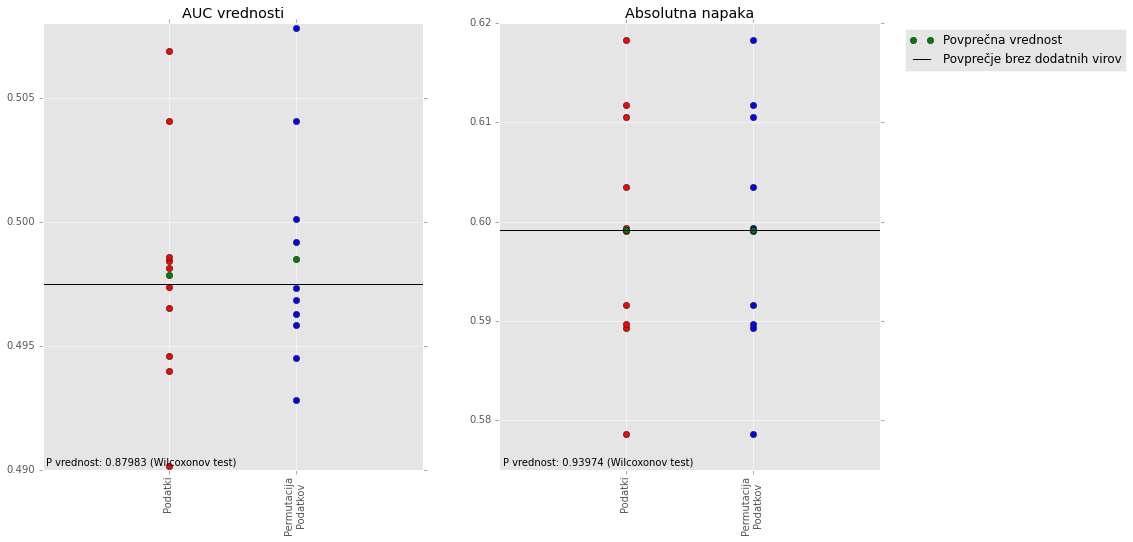

In [12]:
print('with GO terms:')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(rna_GO, genes, GO)]

row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='row', graphlines = [rauc, rdev])

with gamma-proteobacter Orthology to AA proteins
	AUC value is: 0.481046275096
		all values: [0.46836113985046696, 0.47393089278406203, 0.49356458175943307, 0.46205762015475882, 0.46482356680660164, 0.48037957456776847, 0.50107733376931818, 0.48550214450916201, 0.49452622166897803, 0.48623967509323057]

	Average deviation is: 0.599120201123
		all values: [0.61169324338712494, 0.60339594627251669, 0.57860167083368086, 0.58922636424139108, 0.58967492069868976, 0.59938305965687677, 0.61832210885177019, 0.59896512971357529, 0.61036006721798464, 0.59157950035976492]


Shuffling by col
	AUC value is: 0.479260631596
		all values: [0.4673296356364382, 0.46376208286040199, 0.49844067770296657, 0.48310372204632412, 0.4668794121749919, 0.47505347107357959, 0.48188827795185141, 0.48336587736884223, 0.48809001223582327, 0.48469314690830168]

	Average deviation is: 0.599097592929
		all values: [0.61159001237676824, 0.60333550632691424, 0.57855004864677795, 0.58923243513626034, 0.58962158413891508, 0

(0.48104627509637804, 0.59912020112333741)

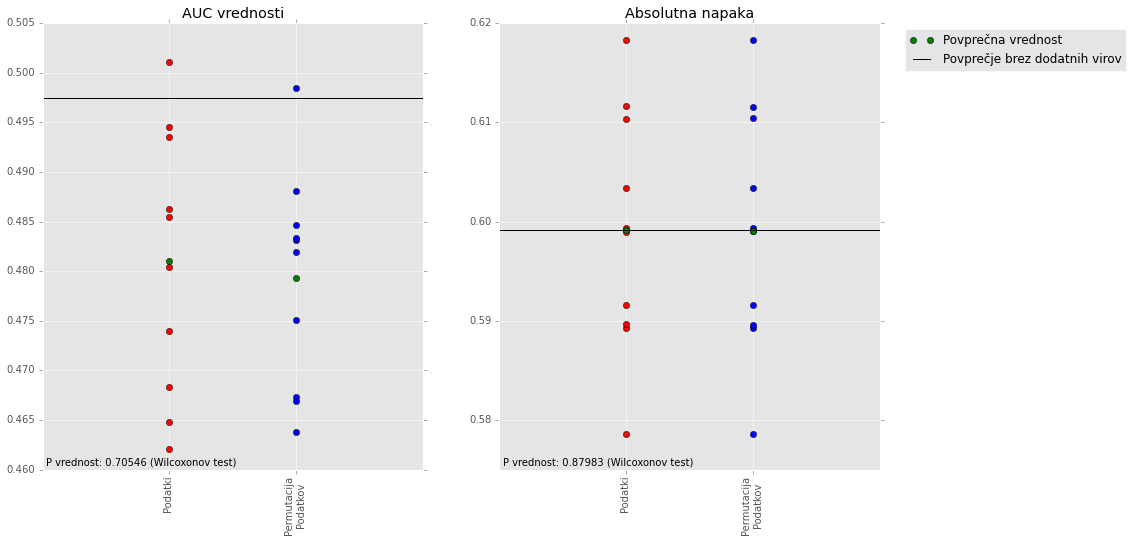

In [13]:
print('with gamma-proteobacter Orthology to AA proteins')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(aaexp_prot, aaexp, prot)]
row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])

with gamma-proteobacter Orthology to HS genes
	AUC value is: 0.470910342972
		all values: [0.47773096692906419, 0.45380999138678357, 0.45288606395629294, 0.43959682375664005, 0.48353438313049557, 0.38842549742764076, 0.52778792943717912, 0.48613189827718895, 0.46868948737139343, 0.53051038804599771]

	Average deviation is: 0.599167070822
		all values: [0.61176820585570479, 0.60343893750687883, 0.57859312965338783, 0.58926600619994485, 0.58969794244278029, 0.59938765867172117, 0.61833114536541101, 0.59908501461357511, 0.61050601980267294, 0.59159664810887846]


Shuffling by col
	AUC value is: 0.486909899586
		all values: [0.47708854887282803, 0.45370922261836233, 0.4469935304612635, 0.43462918738948725, 0.5444703546138705, 0.50027113689347447, 0.53680002889430145, 0.48918146248195876, 0.46936189080492818, 0.51659363283077331]

	Average deviation is: 0.599167075779
		all values: [0.61176821006534376, 0.60343893787872538, 0.57859312998460388, 0.58926599884037767, 0.58969795803224634, 0.59

(0.47091034297186762, 0.59916707082209553)

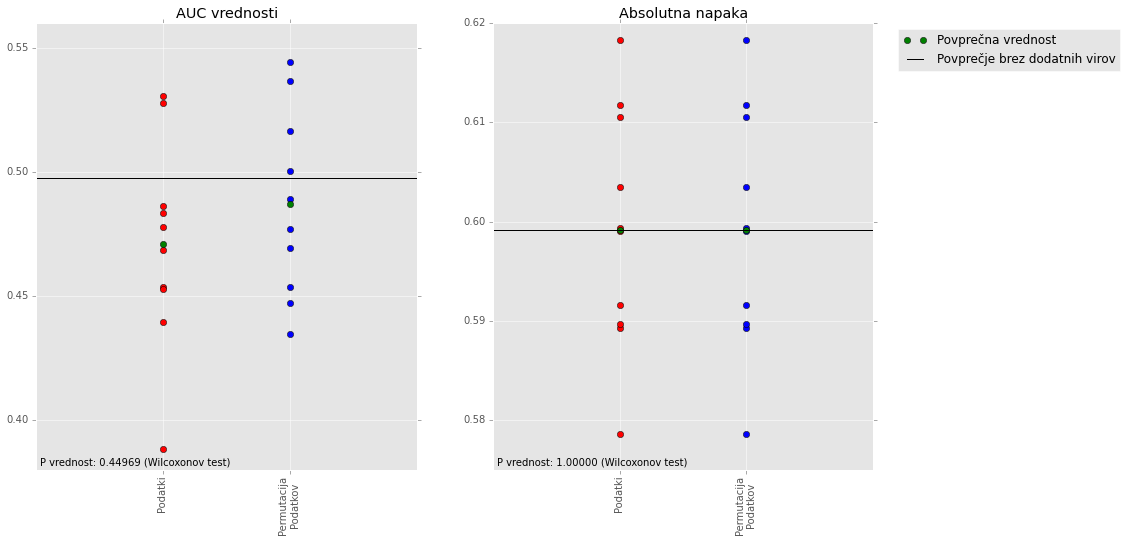

In [14]:
auc_th = 2.5

print('with gamma-proteobacter Orthology to HS genes')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(hsgene_gproOG, genes, gproOG)]
row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])